In this notebook we test two linear interpolation packages with our photo-z results data.

In [1]:
### Import needed packages
import os
import numpy as np
from copy import deepcopy
# import pandas as pd
# import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import griddata
from sklearn import linear_model

In [2]:
### Read the photo-z results data into numpy arrays

### Read in the limiting magnitudes from grid_stddevs.dat
points = np.loadtxt( 'grid_stddevs.dat', dtype='float', usecols=(0,1,2,3,4,5))

### Read in the standard deviation in lowest redshift bin from grid_stddevs.dat
values = np.loadtxt( 'grid_stddevs.dat', dtype='float', usecols={6})

### Define test points in 6D-space at which to interpolate.
###    Option 1: slight offset from first few the runs
xi = np.asarray( [points[0]+0.02,\
                  points[1]-0.02,\
                  points[2]+0.05], dtype='float' )
print(points[0],values[0])
print(points[1],values[1])
print(points[2],values[2])
###    Option 2: generic user inputs
# xi = np.asarray( [[25.0, 27.0, 27.0, 26.0, 25.0, 24.0],\
#                   [25.5, 27.5, 27.5, 26.5, 25.5, 24.5],\
#                   [24.5, 26.5, 26.5, 25.5, 24.5, 23.5]], dtype='float' )

### Quick check on the shapes of our arrays.
### For scipy.interpolate, the data format must be as follows
###    points:  ndarray of floats, shape (n, D)
###    values:  ndarray of float or complex, shape (n,)
###    xi:      2-D ndarray of float or tuple of 1-D array, shape (M, D)
print('Check shapes:')
print(points.shape,values.shape,xi.shape)

[ 26.09  27.38  27.53  26.83  26.05  24.86] 0.0242
[ 23.15  27.38  27.53  26.83  26.05  24.86] 0.0274
[ 23.9   27.38  27.53  26.83  26.05  24.86] 0.0266
Check shapes:
(155, 6) (155,) (3, 6)


In [3]:
### Apply scipy.interpolate's griddata

### method='nearest'; "returns the value at the data point closest to the point of interpolation"
results = griddata(points,values,xi,method='nearest')
print('method = nearest')
print(results)
del results

### method='linear' -- it will return NaN's indicating failures
results = griddata(points,values,xi,method='linear')
print('method = linear')
print(results)
del results

method = nearest
[ 0.0239  0.0274  0.0266]
method = linear
[ nan  nan  nan]


Based on the above, we can see that scipy.interpolate.griddata with method='linear' fails for our data set. <br>
We need to better sample the 6D parameter space in order to use scipy.interpolate.griddata with method='linear'. <br> 
Instead, let's try sklearn's linear_model for this work.<br><br><br>

In [4]:
### Apply sklearn's linear_model
reg = linear_model.LinearRegression()
reg.fit(points,values)
print("Coefficients: ", reg.coef_)
print("Intercept: ", reg.intercept_)
print('reg.predict(xi) = ', reg.predict(xi) )
del reg

Coefficients:  [-0.00152768 -0.00400098 -0.0068155  -0.00260573  0.00097694  0.00065087]
Intercept:  0.389582204349
reg.predict(xi) =  [ 0.02399924  0.02902351  0.0269452 ]


Based on the above, it appears that sklearn.linear_model.LinearRegressions works well. <br>
Now let's investigate *how well* it works by probing all regions of our parameter space. <br><br><br>

In [5]:
### Loop over our data, remove each point, and then do the interpolation at that point
### Calculate the interpolated value from both the sklearn and scipy interpolators
### Also calculate the 6D distance to the nearest point, and to the baseline (row 0)

sk_results  = np.zeros( len(points), dtype='float' )
sk_diff     = np.zeros( len(points), dtype='float' )
sp_results  = np.zeros( len(points), dtype='float' )
sp_diff     = np.zeros( len(points), dtype='float' )
dm_nearest  = np.zeros( len(points), dtype='float' )
dm_baseline = np.zeros( len(points), dtype='float' )

for i in range(len(points)):
    ### Make deep copies of the points and values
    temp1 = deepcopy(points)
    temp2 = deepcopy(values)
    ### Remove the ith row of each of these arrays and delete temps
    newpoints = np.delete(temp1,i,axis=0)
    newvalues = np.delete(temp2,i,axis=0)
    del temp1,temp2
    ### Interpolate at the removed point
    ### For this point, calculate the 6D distance to:
    ###  (1) the nearest grid point 
    ###  (2) the point that represents a baseline survey (row=0)
    newxi = deepcopy(points[i])
    dm_nearest[i]  = np.min( np.sqrt( np.sum( (newpoints-newxi)**2, axis=1 ) ) )
    dm_baseline[i] = np.sqrt( np.sum( (points[0]-newxi)**2 ) )
    ###  (1) Using sklearn's linear_model
    reg = linear_model.LinearRegression()
    reg.fit(newpoints,newvalues)
    tmp = newxi.reshape(1,-1) ### If we don't reshape, deprecation error
    sk_results[i] = reg.predict(tmp)
    sk_diff[i]    = np.abs(values[i] - sk_results[i])
    del reg,tmp
    ###  (2) Using scipy's interpolate.griddata with method=nearest
    sp_results[i] = griddata(newpoints,newvalues,newxi,method='nearest')
    sp_diff[i]    = np.abs(values[i] - sp_diff[i])
    ### Clean up
    del newpoints,newvalues,newxi

print('This cell runs silent. Done.')

This cell runs silent. Done.


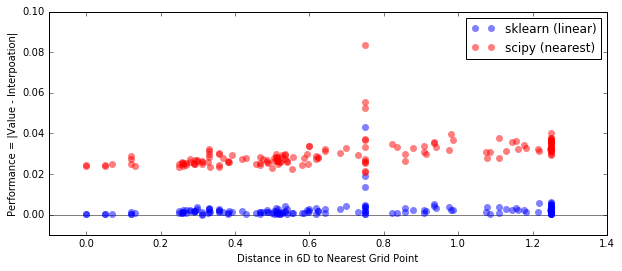

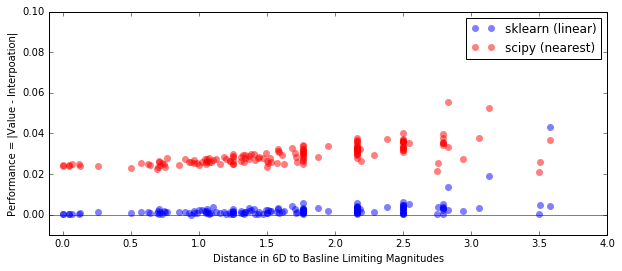

In [6]:
### Plot the performance of each of these interpolations as a function of:
###  (1) The 6D distance to the nearest grid point
###  (2) The 6D distance to the baseline set of limiting magnitudes

plt.figure(figsize=(10,4))
plt.axhline(0.0,color='grey')
plt.plot(dm_nearest, sk_diff, 'o', ms=7, alpha=0.5, mew=0, color='blue', label='sklearn (linear)')
plt.plot(dm_nearest, sp_diff, 'o', ms=7, alpha=0.5, mew=0, color='red', label='scipy (nearest)')
plt.xlabel('Distance in 6D to Nearest Grid Point')
plt.ylabel('Performance = |Value - Interpoation|')
plt.legend(loc='upper right')
plt.xlim([-0.1,1.4])
plt.ylim([-0.01,0.10])
plt.show()

plt.figure(figsize=(10,4))
plt.axhline(0.0,color='grey')
plt.plot(dm_baseline, sk_diff, 'o', ms=7, alpha=0.5, mew=0, color='blue', label='sklearn (linear)')
plt.plot(dm_baseline, sp_diff, 'o', ms=7, alpha=0.5, mew=0, color='red', label='scipy (nearest)')
plt.xlabel('Distance in 6D to Basline Limiting Magnitudes')
plt.ylabel('Performance = |Value - Interpoation|')
plt.legend(loc='upper right')
plt.xlim([-0.1,4.0])
plt.ylim([-0.01,0.10])
plt.show()

Conclusions: <br>
(1) sklearn.linear_model delivers improved results over scipy.interpolate (obvious and expected) <br>
(2) performance is worse in sparsely-sampled regions of 6D parameter space (obvious and expected) <br>
(3) performance is worse in regions of 6D parameter space away from the 'baseline) <br>
<br>
Thus, more grid points should be generated, and these grid points should sample regions of 6D parameter space well away from the baseline.<br>
But where exactly should we do more runs?<br><br><br>

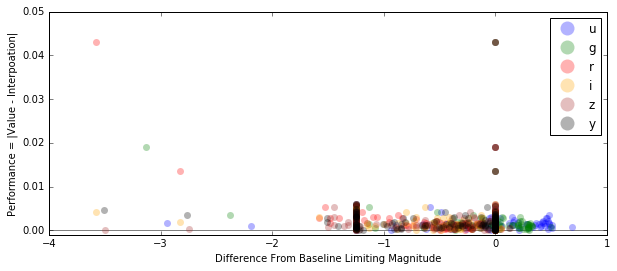

In [7]:
### For each filter, plot the performance of the sklearn interpolator
### as a function of distance from the baseline limiting magnitude

filt_clrs = ['blue','green','red','orange','brown','black']
bl_maglims = points[0]

### Each filter gets its own plot
# for f,filt in enumerate(['u','g','r','i','z','y']):
#     plt.figure(figsize=(6,3))
#     plt.axhline(0.0,color='grey')
#     xvals = points.T[f]
#     plt.plot(xvals-bl_maglims[f], sk_diff, 'o', ms=7, alpha=0.3, mew=0, color=filt_clrs[f], label=filt)
#     plt.xlabel('Difference From Baseline Limiting Magnitude')
#     plt.ylabel('Performance = |Value - Interpoation|')
#     plt.legend(loc='upper left',numpoints=1,markerscale=2)
#     plt.xlim([-4,1])
#     plt.ylim([-0.001,0.05])
#     plt.show()

### Overplot all filters
plt.figure(figsize=(10,4))
plt.axhline(0.0,color='grey')
for f,filt in enumerate(['u','g','r','i','z','y']):
    xvals = points.T[f]
    plt.plot(xvals-bl_maglims[f], sk_diff, 'o', ms=7, alpha=0.3, mew=0, color=filt_clrs[f], label=filt)
plt.xlabel('Difference From Baseline Limiting Magnitude')
plt.ylabel('Performance = |Value - Interpoation|')
plt.legend(loc='upper right',numpoints=1,markerscale=2)
plt.xlim([-4,1])
plt.ylim([-0.001,0.05])
plt.show()

Conclusions: <br>
(1) As previously surmised, more runs should be done for limiting magnitudes that are very different from the baseline.<br>
(2) But more runs *also* need to be run near the baseline, where performance is poor sometimes.<br>
(3) It's clear that only u- and g-band have many grid points fainter than the baseline; more runs with fainter limits in rizy should be run. <br><br>